# Simple Reinforcement Learning with Tensorflow Part 0: Q-Learning with Tables and Neural Networks

https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-0-q-learning-with-tables-and-neural-networks-d195264329d0

## Notes

### Q-Learning algorithms

Q-Learning attempts to learn the value of being in a given state, and taking a specific action there - unlike policy gradient methods, which attempt to learn functions which directly map an observation to an action.

While both approaches ultimately allow us to take intelligent actions given a situation, the means of getting to that action differ significantly.

Instead of starting with a complex and unwieldy deep neural network, we will begin by implementing a simple lookup-table version of the algorithm, and then show how to implement a neural-network equivalent using Tensorflow. 

In it’s simplest implementation, Q-Learning is a table of values for every state (row) and action (column) possible in the environment. Within each cell of the table, we learn a value for how good it is to take a given action within a given state.

### Belman's Equation for Q-Learning

We make updates to our Q-table using something called the Bellman equation, which states that the expected long-term reward for a given action is equal to the immediate reward from the current action combined with the expected reward from the best future action taken at the following state. In this way, we reuse our own Q-table when estimating how to update our table for future actions! 

In equation form, the rule looks like this:

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0fe1ed37fa6eb19e26b55529c42f9d65b8f14a35)

This says that the Q-value for a given state (s) and action (a) should represent the current reward (r) plus the maximum discounted (γ) future reward expected according to our own table for the next state (s’) we would end up in. The discount variable allows us to decide how important the possible future rewards are compared to the present reward. 

If you think of the Q algorithm in the context of gradient descent, then `r + γ(max(Q(s’,a’))` is what we would like to approach, but we know that it is a noisy estimate of the true Q value for that given region. So instead of directly updating toward it, we take a small step in the direction that will make the Q value closer to the desired one.

By updating in this way, the table slowly begins to obtain accurate measures of the expected future reward for a given action in a given state.

### The FrozenLake Environment

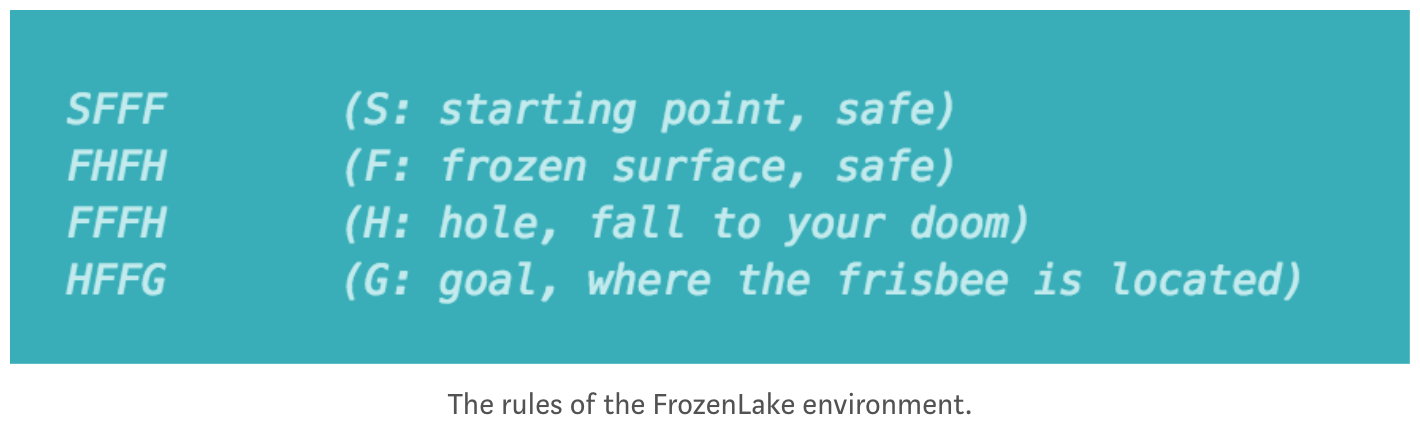

https://gym.openai.com/envs/FrozenLake-v0/

The agent controls the movement of a character in a grid world. Some tiles of the grid are walkable, and others lead to the agent falling into the water. Additionally, the movement direction of the agent is uncertain and only partially depends on the chosen direction (i.e. due to wind). The agent is rewarded for finding a walkable path to a goal tile.

Perfect performance every time is impossible, but learning to avoid the holes and reach the goal are certainly still doable. The reward at every step is 0, except for entering the goal, which provides a reward of 1. Thus, we will need an algorithm that learns long-term expected rewards. This is exactly what Q-Learning is designed to provide.



#### Matrix Implementation

In the case of the FrozenLake environment, we have 16 possible states (one for each block), and 4 possible actions (the four directions of movement), giving us a 16x4 table of Q-values. 

We start by initializing the table to be uniform (all zeros), and then as we observe the rewards we obtain for various actions, we update the table accordingly.

#### Neural Network Implementation

Tables are great, but they don’t really scale. While it is easy to have a 16x4 table for a simple grid world, the number of possible states in any modern game or real-world environment is nearly infinitely larger. For most interesting problems, tables simply don’t work.

We instead need some way to take a description of our state, and produce Q-values for actions without a table: that is where neural networks come in. By acting as a function approximator, we can take any number of possible states that can be represented as a vector and learn to map them to Q-values.

In the case of the FrozenLake example, we will be using a one-layer network which takes the state encoded in a one-hot vector (1x16), and produces a vector of 4 Q-values, one for each action.

Such a simple network acts kind of like a glorified table, with the network weights serving as the old cells. The key difference is that we can easily expand the Tensorflow network with added layers, activation functions, and different input types, whereas all that is impossible with a regular table.

The method of updating is a little different as well. Instead of directly updating our table, with a network we will be using backpropagation and a loss function. Our loss function will be sum-of-squares loss, where the difference between the current predicted Q-values, and the “target” value is computed and the gradients passed through the network. In this case, our Q-target for the chosen action is the equivalent to the Q-value computed in Bellman's equation above.

Eq2. Loss = ∑(Q-target - Q)²

While the network learns to solve the FrozenLake problem, it turns out it doesn’t do so quite as efficiently as the Q-Table. While neural networks allow for greater flexibility, they do so at the cost of stability when it comes to Q-Learning.

There are a number of possible extensions to our simple Q-Network which allow for greater performance and more robust learning. Two tricks in particular are referred to as Experience Replay and Freezing Target Networks. Those improvements and other tweaks were the key to getting Atari-playing Deep Q-Networks.

For more info on the theory behind Q-Learning, see this great post by Tambet Matiisen: http://neuro.cs.ut.ee/demystifying-deep-reinforcement-learning/.

## Coding

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
import tensorflow as tf
tf.reset_default_graph()

env = gym.make('FrozenLake-v0')
print(env.action_space)
print(env.observation_space)
print(env.reward_range)
print(env.reset())
print(env.action_space.sample())

Discrete(4)
Discrete(16)
(-inf, inf)
0
0


### Implement Q-Table learning algorithm¶

#### Implement Training

In [2]:
#Initialize table with all zeros
Q = np.zeros([env.observation_space.n, env.action_space.n])

# Set learning parameters
lr = 0.8
y = .99

max_time_to_goal = 99
num_episodes = 4000

# create lists to contain total rewards
table_rList = []
table_jList = []
for i in range(num_episodes):
    #Reset environment and get first new observation
    s = env.reset()
    rAll = 0
    d = False
    j = 0

    # The Q-Table learning algorithm
    while j < max_time_to_goal:
        j+=1
        # Choose an action by greedily (with noise) picking from Q table
        # Adding noise as a means of encouraging exploration
        a = np.argmax(Q[s,:] + np.random.randn(1,env.action_space.n)*(1./(i+1)))

        # Get new state and reward from environment
        s1, r, d, info = env.step(a)

        # Update Q-Table with new knowledge
        Q[s,a] += lr*(r + y*np.max(Q[s1,:]) - Q[s,a])
        rAll += r
        s = s1
        if d == True:
            break

    table_jList.append(j)
    table_rList.append(rAll)


Score over time: 0.50075


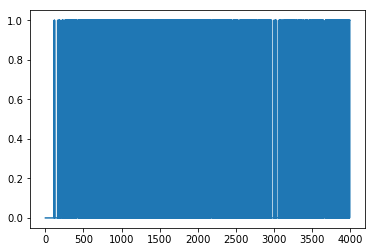

First 20 attempts


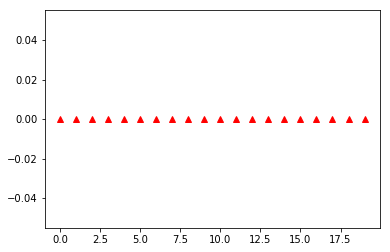

Last 20 attempts


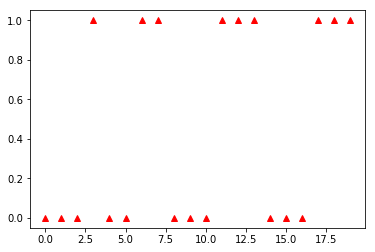

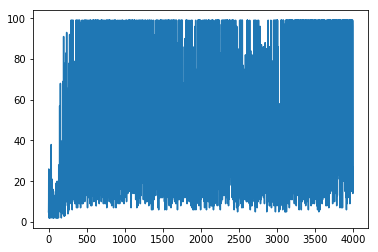

[[  2.22004338e-03   6.82633130e-01   0.00000000e+00   3.25355451e-03]
 [  6.30803285e-04   1.25936171e-03   0.00000000e+00   3.59043479e-01]
 [  1.36782868e-03   1.90908049e-03   2.23711710e-03   2.68813089e-01]
 [  1.23836010e-03   8.78341224e-04   1.17777825e-03   2.11086147e-01]
 [  8.21713662e-01   3.37918581e-04   1.32992608e-04   4.10109407e-04]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  2.98520247e-01   9.47978118e-07   6.30398652e-04   3.36125982e-05]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  3.21082113e-04   3.29864059e-04   4.85679209e-04   6.41343257e-01]
 [  0.00000000e+00   7.83852497e-01   1.46681122e-04   2.59539673e-04]
 [  7.49773179e-01   3.84782017e-05   4.35135320e-04   3.71903131e-06]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  2.19834247e-03   4.12850809e-03   9.32532235e-01   6.60735408e-03]
 [  0.

In [3]:
print("Score over time: " +  str(sum(table_rList)/num_episodes))

plt.plot(table_rList)
plt.show()
plt.close()

print("First 20 attempts")
plt.plot(range(20), table_rList[:20], 'r^')
plt.show()
plt.close()

print("Last 20 attempts")
plt.plot(range(20), table_rList[-20:], 'r^')
plt.show()
plt.close()


plt.plot(table_jList)
plt.show()
plt.close()


# print("Final Q-Table Values")
print(Q)

#### Test the training results

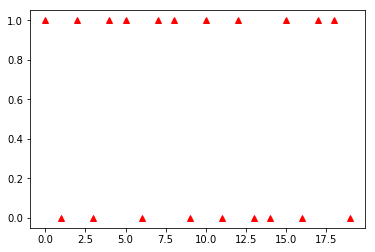

In [4]:
# Testing the results
test_res = []
max_time_to_goal = 500

for i in range(20):
    s = env.reset()

    rAll = 0
    d = False
    j = 0

    while j < max_time_to_goal:
        j+=1
        # Choose an action by greedily picking from Q table for the current state
        a = np.argmax(Q[s,:])

        # Get new state and reward from environment
        s1, r, d, info = env.step(a)

        rAll += r
        s = s1
        if d == True:
            break

    test_res.append(rAll)

    
plt.plot(range(len(test_res)), test_res, 'r^')
plt.show()
plt.close()


### Implementing Neural network

In [5]:
# Tensorflow "Hello world"
hello = tf.constant('Hello, TensorFlow!')
sess = tf.Session()
print(sess.run(hello))

sess.close()

b'Hello, TensorFlow!'


In [6]:
# https://stackoverflow.com/questions/38189119/simple-way-to-visualize-a-tensorflow-graph-in-jupyter
# https://blog.jakuba.net/2017/05/30/tensorflow-visualization.html
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1000px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

#### Implementing the Network

In [7]:
try:
    test_sess.close()
    tf.reset_default_graph()
except:
    pass
finally:
    test_sess  = tf.Session()
testW = tf.Variable(tf.random_uniform([env.observation_space.n, env.action_space.n], 0, 0.01))

test_sess.run(tf.global_variables_initializer())
print(test_sess.run(testW))
print(test_sess.run(testW) == test_sess.run(testW))

test_sess.close()

[[  7.42571708e-03   7.98502751e-03   5.27803646e-03   3.65139963e-03]
 [  6.03198987e-06   1.95942633e-03   6.57638675e-03   7.45169027e-03]
 [  3.03475023e-03   7.81986024e-03   6.80323364e-03   7.67977210e-03]
 [  8.58681556e-03   7.54921278e-03   2.87093525e-03   4.86421911e-03]
 [  4.27242648e-03   4.19088360e-03   6.89421897e-04   3.24109080e-03]
 [  8.00495129e-03   9.49686742e-04   6.22604461e-03   5.02615795e-03]
 [  2.92151212e-03   6.97399117e-03   4.73839277e-03   9.24494863e-03]
 [  7.98039138e-03   7.56139122e-03   4.61587403e-03   4.98305541e-03]
 [  6.39766781e-03   9.53066722e-03   1.29752036e-03   4.98663308e-03]
 [  3.23945400e-03   6.64350018e-03   5.08772954e-03   6.96468819e-03]
 [  3.25828791e-04   7.25527247e-03   2.10761908e-03   3.30230943e-03]
 [  8.81959312e-03   3.50398058e-03   2.35856418e-03   9.48647968e-03]
 [  7.00058462e-03   2.19140039e-03   4.41360008e-03   6.42401073e-03]
 [  9.41592548e-03   5.26465150e-03   2.40926025e-03   4.43261396e-03]
 [  7.

In [8]:
try:
    sess.close()
    tf.reset_default_graph()
except:
    pass
finally:
    sess = tf.Session()

# These lines establish the feed-forward part of the network used to choose actions
inputs1 = tf.placeholder(shape=[1, env.observation_space.n], dtype=tf.float32, name="Current-State-Input")
# Initialize the weights of the neural links between the input nodes and each action node
W = tf.Variable(tf.random_uniform([env.observation_space.n, env.action_space.n], 0, 0.01), name="Input-to-Action-Weights")
# Caliculating the output nodes for a given input
Qout = tf.matmul(inputs1, W, name="Predicted-Actions-Quality")
# Each predicted action is the maximum output node for the given input
predict = tf.argmax(Qout, 1, name="Predicted-Best-Action")

# Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
nextQ = tf.placeholder(shape=[1, env.action_space.n], dtype=tf.float32, name="Actual-Action-Quality")
# Get the square difference for each cell and sum over all cells
loss = tf.reduce_sum(tf.square(nextQ - Qout), name="Current-Loss")
# Initialize a gradient descent trainer which will change the weights to reach a stable point
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1, name="Optimize-Weights-Gradient-Descent")
# Define the calculation goal - find a minimum loss
updateModel = trainer.minimize(loss)

print("Variables that will be trained:", tf.trainable_variables()[0])
show_graph(tf.get_default_graph())


Variables that will be trained: <tf.Variable 'Input-to-Action-Weights:0' shape=(16, 4) dtype=float32_ref>


In [9]:
init = tf.global_variables_initializer()

# Set learning parameters
y = .99
e = 0.1
num_episodes = 2000

# create lists to contain total rewards and steps per episode
jList = []
rList = []

with tf.Session() as sess:
    sess.run(init)
    for i in range(num_episodes):
        # Reset environment and get first new observation
        s = env.reset()
        rAll = 0
        d = False
        j = 0
        # The Q-Network
        while j < 99:
            j+=1
            # Choose an action by greedily (with e chance of random action) from the Q-network
            # sess.run Runs operations and evaluates tensors in fetches.
            a, allQ = sess.run([predict, Qout], feed_dict={inputs1: np.identity(16)[s:s+1]})
            
            chosen_action = env.action_space.sample() if np.random.rand(1) < e else a[0]

            # Get new state and reward from environment
            s1,r,d,_ = env.step(chosen_action)

            # Obtain the Q' values by feeding the new state through our network
            Q1 = sess.run(Qout, feed_dict={inputs1: np.identity(16)[s1:s1+1]})

            # Obtain maxQ' and set our target value for chosen action.
            maxQ1 = np.max(Q1)
            targetQ = allQ
            targetQ[0, chosen_action] = r + y*maxQ1

            # Train our network using target and predicted Q values
            # last_W1 = W1
            _,W1 = sess.run([updateModel, W],feed_dict={inputs1: np.identity(16)[s:s+1],
                                                        nextQ: targetQ})
            # print(last_W1 == W1)
            rAll += r
            s = s1
            if d == True:
                # Reduce chance of random action as we train the model (per episode).
                e = 1. / ((i / 50) + 10)
                break
        jList.append(j)
        rList.append(rAll)

print("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")

Percent of succesful episodes: 0.0%


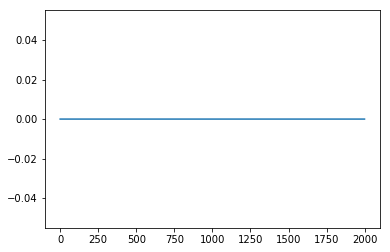

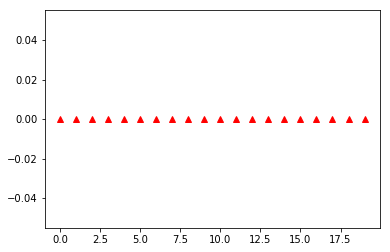

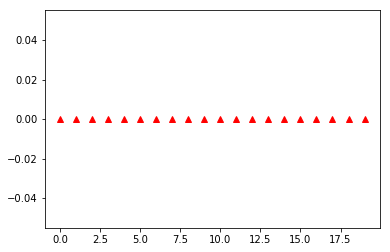

We can see that the network beings to consistly reach the goal around the 750 episode mark.
It also begins to progress through the environment for longer than chance aroudn the 750 mark as well.


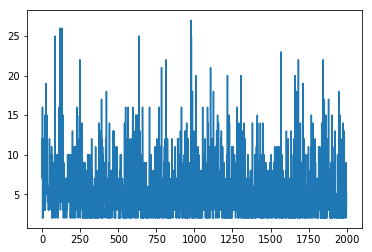

In [10]:
plt.plot(rList)
plt.show()
plt.close()

plt.plot(range(len(rList[:20])), rList[:20], 'r^')
plt.show()
plt.close()

plt.plot(range(len(rList[-20:])), rList[-20:], 'r^')
plt.show()
plt.close()

print("We can see that the network beings to consistly reach the goal around the 750 episode mark.\n"
"It also begins to progress through the environment for longer than chance aroudn the 750 mark as well.")
plt.plot(jList)
plt.show()
plt.close()

# Simple Reinforcement Learning in Tensorflow: Part 1 - Two-armed Bandit

Reinforcement learning provides the capacity for us not only to teach an artificial agent how to act, but to allow it to learn through it’s own interactions with an environment.

Learning how to build these agents requires a bit of a change in thinking for anyone used to working in a supervised learning setting though. Gone is the ability to simply get the algorithm to pair certain stimuli with certain responses.

RL algorithms must enable the agent to learn the correct pairings itself through the use of observations, rewards, and actions. Since there is no longer a “True” correct action for an agent to take in any given circumstance that we can just tell it, things get a little tricky.

## Notes

### Two-armed Bandit

The simplest reinforcement learning problem is the n-armed bandit.

Essentially, there are n-many slot machines, each with a different fixed payout probability. The goal is to discover the machine with the best payout, and maximize the returned reward by always choosing it.

We are going to make it even simpler, by only having two possible slot machines to choose between. In fact, this problem is so simple that it is more of a precursor to real RL problems than one itself.

Let me explain. Typical aspects of a task that make it an RL problem are the following:
1. Different actions yield different rewards. For example, when looking for treasure in a maze, going left may lead to the treasure, whereas going right may lead to a pit of snakes.
2. Rewards are delayed over time. This just means that even if going left in the above example is the right things to do, we may not know it till later in the maze.
3. Reward for an action is conditional on the state of the environment. Continuing the maze example, going left may be ideal at a certain fork in the path, but not at others.

The n-armed bandit is a nice starting place because we don’t have to worry about aspects #2 and 3. All we need to focus on is learning which rewards we get for each of the possible actions, and ensuring we chose the optimal ones.

In the context of RL lingo, this is called learning a policy.

We are going to be using a method called policy gradients, where our simple neural network learns a policy for picking actions by adjusting it’s weights through gradient descent using feedback from the environment.

There is another approach to reinforcement learning where agents learn value functions. In those approaches, instead of learning the optimal action in a given state, the agent learns to predict how good a given state or action will be for the agent to be in. Both approaches allow agents to learn good behavior, but the policy gradient approach is a little more direct.

In the case of our bandit, we don’t need to condition these outputs on any state. As such, our network will consist of just a set of weights, with each corresponding to each of the possible arms to pull in the bandit, and will represent how good our agent thinks it is to pull each arm. If we initialize these weights to 1, then our agent will be somewhat optimistic about each arm’s potential reward.

### Policy Gradients

The simplest way to think of a Policy gradient network is one which produces explicit outputs.


To update our network, we will simply try an arm with an e-greedy policy. This means that most of the time our agent will choose the action that corresponds to the largest expected value, but occasionally, with e probability, it will choose randomly. In this way, the agent can try out each of the different arms to continue to learn more about them.

Once our agent has taken an action, it then receives a reward of either 1 or -1. With this reward, we can then make an update to our network using the policy loss equation:

Loss = -log(π)*A

- A is advantage, and is an essential aspect of all reinforcement learning algorithms. Intuitively it corresponds to how much better an action was than some baseline. In future algorithms, we will develop more complex baselines to compare our rewards to, but for now we will assume that the baseline is 0, and it can be thought of as simply the reward we received for each action.
- π is the policy. In this case, it corresponds to the chosen action’s weight.

Intuitively, this loss function allows us to increase the weight for actions that yielded a positive reward, and decrease them for actions that yielded a negative reward. In this way the agent will be more or less likely to pick that action in the future. By taking actions, getting rewards, and updating our network in this circular manner, we will quickly converge to an agent that can solve our problem!

## Code

### Setup

In [12]:
import tensorflow as tf
import numpy as np

### Bandits
Here we define our bandits. For this example we are using a four-armed bandit. The pullBandit function generates a random number from a normal distribution with a mean of 0. The lower the bandit number, the more likely a positive reward will be returned. We want our agent to learn to always choose the bandit that will give that positive reward.

In [13]:
# List out our bandits. Currently bandit 4 (index#3) is set to most often provide a positive reward.
bandits = [0.2, 0, -0.2, -5]
num_bandits = len(bandits)
def pullBandit(bandit):
    #G et a random number.
    result = np.random.randn(1)
    if result > bandit:
        #return a positive reward.
        return 1
    else:
        #return a negative reward.
        return -1

### Agent
The code below established our simple neural agent. It consists of a set of values for each of the bandits. Each value is an estimate of the value of the return from choosing the bandit. We use a policy gradient method to update the agent by moving the value for the selected action toward the recieved reward.

In [17]:
tf.reset_default_graph()

#These two lines established the feed-forward part of the network. This does the actual choosing.
weights = tf.Variable(tf.ones([num_bandits]), name="bandit-weights")
chosen_action = tf.argmax(weights,0, name="chosen-action")

#The next six lines establish the training proceedure. We feed the reward and chosen action into the network
#to compute the loss, and use it to update the network.
reward_holder = tf.placeholder(shape=[1], dtype=tf.float32, name="reward")
action_holder = tf.placeholder(shape=[1], dtype=tf.int32, name="action")
responsible_weight = tf.slice(weights, action_holder, [1], name="policy-pi")
loss = -(tf.log(responsible_weight) * reward_holder)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001, name="loss-optimizer")
update = optimizer.minimize(loss)

print("Variables that will be trained:", tf.trainable_variables()[0])
show_graph(tf.get_default_graph())

Variables that will be trained: <tf.Variable 'bandit-weights:0' shape=(4,) dtype=float32_ref>


### Training the Agent
We will train our agent by taking actions in our environment, and recieving rewards. Using the rewards and actions, we can know how to properly update our network in order to more often choose actions that will yield the highest rewards over time.

In [18]:
total_episodes = 1000  # Set total number of episodes to train agent on.
total_reward = np.zeros(num_bandits) # Set scoreboard for bandits to 0.
e = 0.1 # Set the chance of taking a random action.

init = tf.global_variables_initializer()

# Launch the tensorflow graph
with tf.Session() as sess:
    sess.run(init)
    i = 0
    while i < total_episodes:
        
        #Choose either a random action or one from our network.
        if np.random.rand(1) < e:
            action = np.random.randint(num_bandits)
        else:
            action = sess.run(chosen_action)
        
        reward = pullBandit(bandits[action])  # Get our reward from picking one of the bandits.
        
        # Update the network.
        _,resp,ww = sess.run([update,responsible_weight,weights],
                             feed_dict={reward_holder:[reward],action_holder:[action]})
        
        #Update our running tally of scores.
        total_reward[action] += reward
        if i % 50 == 0:
            print("Running reward for the " + str(num_bandits) + " bandits: " + str(total_reward))
        i+=1

print("The agent thinks bandit " + str(np.argmax(ww)+1) + " is the most promising....")
if np.argmax(ww) == np.argmax(-np.array(bandits)):
    print("...and it was right!")
else:
    print("...and it was wrong!")


Instructions for updating:
Use `tf.global_variables_initializer` instead.
Running reward for the 4 bandits: [-1.  0.  0.  0.]
Running reward for the 4 bandits: [ -1.   0.  -2.  46.]
Running reward for the 4 bandits: [  1.   0.  -2.  92.]
Running reward for the 4 bandits: [   0.    0.   -3.  140.]
Running reward for the 4 bandits: [   1.    0.   -2.  188.]
Running reward for the 4 bandits: [   1.    0.   -1.  235.]
Running reward for the 4 bandits: [  -2.    0.   -2.  281.]
Running reward for the 4 bandits: [  -2.    0.   -2.  325.]
Running reward for the 4 bandits: [  -2.   -1.   -3.  371.]
Running reward for the 4 bandits: [  -3.    0.   -3.  419.]
Running reward for the 4 bandits: [  -3.    0.   -1.  463.]
Running reward for the 4 bandits: [  -3.   -1.   -2.  511.]
Running reward for the 4 bandits: [  -3.    0.   -2.  558.]
Running reward for the 4 bandits: [  -5.    0.    1.  603.]
Running reward for the 4 bandits: [  -4.    0.    1.  648.]
Running reward for the 4 bandits: [  -5.  

# Simple Reinforcement Learning with Tensorflow Part 1.5: Contextual Bandits

## Notes

How to solve problems in which there are states, but they aren’t determined by the previous states or actions.

Additionally, we won’t be considering delayed rewards. 

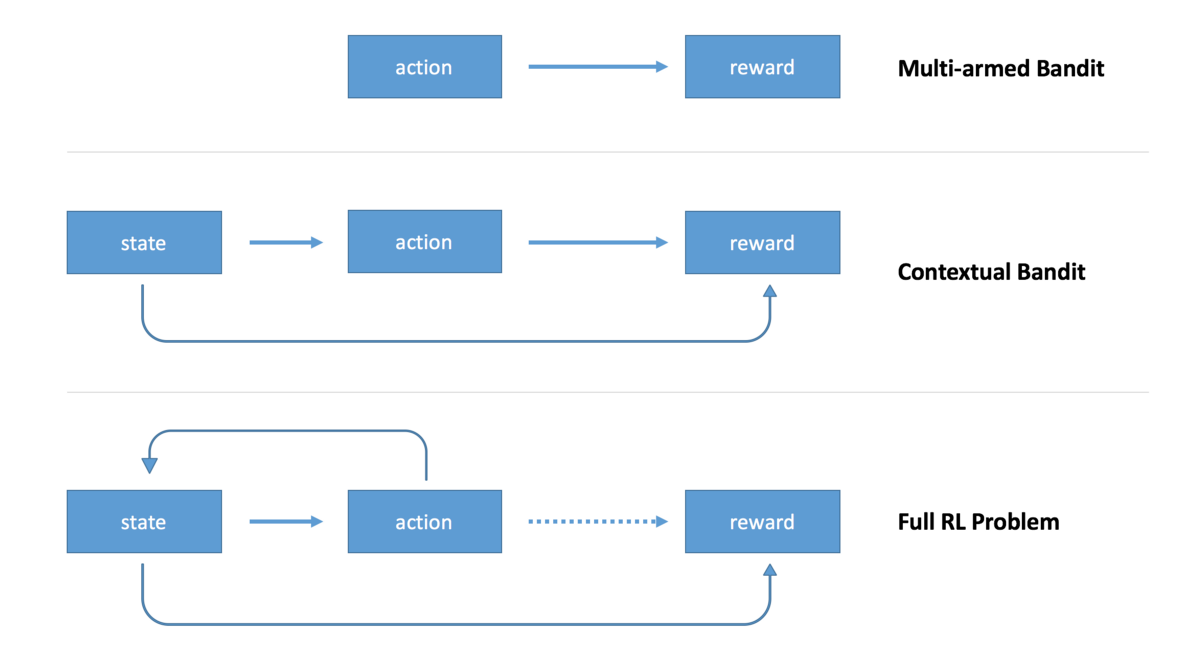
- Above: Multi-armed bandit problem, where only action effect reward.
- Middle: Contextual bandit problem, where state and action effect reward.
- Bottom: Full RL problem, where action effects state, and rewards may be delayed in time.


### Contextual bandit

In the original multi-armed bandit problem there is only a single bandit, which can be thought of as like a slot-machine. The range of actions available to the agent consist of pulling one of multiple arms of the bandit. By doing so, a reward of +1 or -1 is received at different rates. The problem is considered solved if the agent learns to always choose the arm that most often provides a positive reward.

In such a case, we can design an agent that completely ignores the state of the environment, since for all intents and purposes, there is only ever a single, unchanging state.

Contextual Bandits introduce the concept of the state. The state consists of a description of the environment that the agent can use to take more informed actions.

In our problem, instead of a single bandit, there can now be multiple bandits. The state of the environment tells us which bandit we are dealing with, and the goal of the agent is to learn the best action not just for a single bandit, but for any number of them.

Since each bandit will have different reward probabilities for each arm, our agent will need to learn to condition its action on the state of the environment. Unless it does this, it won’t achieve the maximum reward possible over time.

In order to accomplish this, we will be building a single-layer neural network in Tensorflow that takes a state and produces an action. By using a policy-gradient update method, we can have the network learn to take actions that maximize its reward.

### One-hot encoding
https://www.quora.com/What-is-one-hot-encoding-and-when-is-it-used-in-data-science
One hot encoding transforms categorical features to a format that works better with classification and regression algorithms.

Let’s take the following example. I have seven sample inputs of categorical data belonging to four categories. Now, I could encode these to nominal values as I have done here, but that wouldn’t make sense from a machine learning perspective. We can’t say that the category of “Penguin” is greater or smaller than “Human”. Then they would be ordinal values, not nominal.
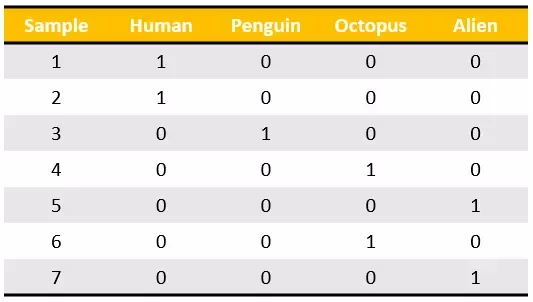

What we do instead is generate one boolean column for each category. Only one of these columns could take on the value 1 for each sample. Hence, the term one hot encoding.
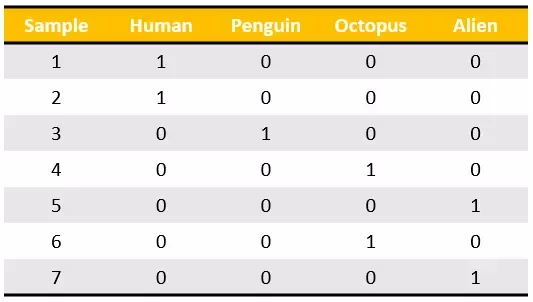

This works very well with most machine learning algorithms. Some algorithms, like random forests, handle categorical values natively. Then, one hot encoding is not necessary. The process of one hot encoding may seem tedious, but fortunately, most modern machine learning libraries can take care of it.

## Code

### Setup

In [20]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import numpy as np

### Contextual Bandits
Here we define our contextual bandits. In this example, we are using three four-armed bandit. What this means is that each bandit has four arms that can be pulled. Each bandit has different success probabilities for each arm, and as such requires different actions to obtain the best result. The pullBandit function generates a random number from a normal distribution with a mean of 0. The lower the bandit number, the more likely a positive reward will be returned. We want our agent to learn to always choose the bandit-arm that will most often give a positive reward, depending on the Bandit presented.


In [21]:
class contextual_bandit(object):
    def __init__(self):
        self.state = 0
        #List out our bandits. Currently arms 4, 2, and 1 (respectively) are the most optimal.
        self.bandits = np.array([[0.2,0,-0.0,-5],
                                 [0.1,-5,1,0.25],
                                 [-5,5,5,5]])
        self.num_bandits = self.bandits.shape[0]
        self.num_actions = self.bandits.shape[1]
        
    def getBandit(self):
        '''Returns a random state for each episode.'''
        self.state = np.random.randint(0, len(self.bandits))
        return self.state
        
    def pullArm(self,action):
        #Get a random number.
        bandit = self.bandits[self.state, action]
        result = np.random.randn(1)
        if result > bandit:
            #return a positive reward.
            return 1
        else:
            #return a negative reward.
            return -1

### The Policy-Based Agent
The code below established our simple neural agent. It takes as input the current state, and returns an action. 

This allows the agent to take actions which are conditioned on the state of the environment, a critical step toward being able to solve full RL problems. The agent uses a single set of weights, within which each value is an estimate of the value of the return from choosing a particular arm given a bandit.

We use a policy gradient method to update the agent by moving the value for the selected action toward the recieved reward.

In [24]:
help(slim.one_hot_encoding)

Help on function one_hot_encoding in module tensorflow.contrib.framework.python.ops.arg_scope:

one_hot_encoding(labels, num_classes, on_value=1.0, off_value=0.0, outputs_collections=None, scope=None)
    Transform numeric labels into onehot_labels using `tf.one_hot`.
    
    Args:
      labels: [batch_size] target labels.
      num_classes: Total number of classes.
      on_value: A scalar defining the on-value.
      off_value: A scalar defining the off-value.
      outputs_collections: Collection to add the outputs.
      scope: Optional scope for name_scope.
    
    Returns:
      One-hot encoding of the labels.



In [28]:
help(slim.fully_connected)

Help on function fully_connected in module tensorflow.contrib.framework.python.ops.arg_scope:

fully_connected(inputs, num_outputs, activation_fn=<function relu at 0x7f1ea25f7400>, normalizer_fn=None, normalizer_params=None, weights_initializer=<function variance_scaling_initializer.<locals>._initializer at 0x7f1e92673d08>, weights_regularizer=None, biases_initializer=<tensorflow.python.ops.init_ops.Zeros object at 0x7f1e926b5b70>, biases_regularizer=None, reuse=None, variables_collections=None, outputs_collections=None, trainable=True, scope=None)
    Adds a fully connected layer.
    
    `fully_connected` creates a variable called `weights`, representing a fully
    connected weight matrix, which is multiplied by the `inputs` to produce a
    `Tensor` of hidden units. If a `normalizer_fn` is provided (such as
    `batch_norm`), it is then applied. Otherwise, if `normalizer_fn` is
    None and a `biases_initializer` is provided then a `biases` variable would be
    created and added 

In [25]:
class agent(object):
    def __init__(self, lr, s_size, a_size):
        # These lines established the feed-forward part of the network.
        # The agent takes a state and produces an action.
        self.state_in = tf.placeholder(shape=[1], dtype=tf.int32, name="state-input")
        state_in_OH = slim.one_hot_encoding(self.state_in, s_size)
        output = slim.fully_connected(state_in_OH, a_size,
                                      biases_initializer=None,
                                      activation_fn=tf.nn.sigmoid,
                                      weights_initializer=tf.ones_initializer())
        self.output = tf.reshape(output, [-1])
        self.chosen_action = tf.argmax(self.output, 0)

        # The next six lines establish the training proceedure. We feed the reward and chosen action into the network
        # to compute the loss, and use it to update the network.
        self.reward_holder = tf.placeholder(shape=[1], dtype=tf.float32, name="reward")
        self.action_holder = tf.placeholder(shape=[1], dtype=tf.int32, name="action")
        self.responsible_weight = tf.slice(self.output, self.action_holder, [1])
        self.loss = -(tf.log(self.responsible_weight) * self.reward_holder)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr, name="loss-optimizer")
        self.update = optimizer.minimize(self.loss)

In [26]:
tf.reset_default_graph() #Clear the Tensorflow graph.

cBandit = contextual_bandit() #Load the bandits.
myAgent = agent(lr=0.001,s_size=cBandit.num_bandits,a_size=cBandit.num_actions) #Load the agent.

print("Variables that will be trained:", tf.trainable_variables()[0])
show_graph(tf.get_default_graph())

Variables that will be trained: <tf.Variable 'fully_connected/weights:0' shape=(3, 4) dtype=float32_ref>


### Training

In [27]:
total_episodes = 10000 # Set total number of episodes to train agent on.
total_reward = np.zeros([cBandit.num_bandits,
                         cBandit.num_actions]) #Set scoreboard for bandits to 0.

e = 0.1 # Set the chance of taking a random action.

init = tf.initialize_all_variables()

# Launch the tensorflow graph
with tf.Session() as sess:
    sess.run(init)
    i = 0
    while i < total_episodes:
        s = cBandit.getBandit() # Get a state from the environment.
        
        # Choose either a random action or one from our network.
        if np.random.rand(1) < e:
            action = np.random.randint(cBandit.num_actions)
        else:
            action = sess.run(myAgent.chosen_action,feed_dict={myAgent.state_in:[s]})
        
        reward = cBandit.pullArm(action) # Get our reward for taking an action given a bandit.
        
         #Update the network.
        feed_dict={myAgent.reward_holder: [reward],
                   myAgent.action_holder: [action],
                   myAgent.state_in:    [s]}
        _,ww = sess.run([myAgent.update,weights], feed_dict=feed_dict)
        
        #Update our running tally of scores.
        total_reward[s,action] += reward
        if i % 500 == 0:
            print("Mean reward for each of the " + str(cBandit.num_bandits) + " bandits: " + str(np.mean(total_reward,axis=1)))
        i+=1

for a in range(cBandit.num_bandits):
    print("The agent thinks action " + str(np.argmax(ww[a])+1) + " for bandit " + str(a+1) + " is the most promising....")
    if np.argmax(ww[a]) == np.argmin(cBandit.bandits[a]):
        print("...and it was right!")
    else:
        print("...and it was wrong!")


Instructions for updating:
Use `tf.global_variables_initializer` instead.
Mean reward for each of the 3 bandits: [-0.25  0.    0.  ]
Mean reward for each of the 3 bandits: [ 33.75  40.    30.  ]
Mean reward for each of the 3 bandits: [ 76.5   72.5   63.25]
Mean reward for each of the 3 bandits: [ 111.    113.75   99.  ]
Mean reward for each of the 3 bandits: [ 148.75  156.25  129.25]
Mean reward for each of the 3 bandits: [ 183.75  194.75  167.25]
Mean reward for each of the 3 bandits: [ 219.    230.75  206.  ]
Mean reward for each of the 3 bandits: [ 254.    270.75  245.  ]
Mean reward for each of the 3 bandits: [ 294.    305.25  279.5 ]
Mean reward for each of the 3 bandits: [ 331.25  339.25  317.25]
Mean reward for each of the 3 bandits: [ 365.    381.5   352.25]
Mean reward for each of the 3 bandits: [ 403.    420.75  388.5 ]
Mean reward for each of the 3 bandits: [ 441.5   461.5   425.25]
Mean reward for each of the 3 bandits: [ 481.25  492.75  463.25]
Mean reward for each of the 

# Simple Reinforcement Learning with Tensorflow: Part 2 - Policy-based Agents

![image.png](https://cdn-images-1.medium.com/max/1200/1*G_whtIrY9fGlw3It6HFfhA.gif)

## Notes

### MDPs

Environments which pose the full problem to an agent are referred to as Markov Decision Processes (MDPs). These environments not only provide rewards and state transitions given actions, but those rewards are also condition on the state of the environment and the action the agent takes within that state. These dynamics are also temporal, and can be delayed over time.